In [1]:
#%%shell

#Install pycocotools
#!sudo git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!sudo python setup.py build_ext install

/mnt/srv/home/dlpc.298/PytorchTutorial/cocoapi/PythonAPI
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> 

In [2]:
#%%shell

# download the Penn-Fudan dataset
#!sudo wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
#extract it in the current folder
#!sudo unzip PennFudanPed.zip

In [5]:
%cd ..

/mnt/srv/home/dlpc.298/PytorchTutorial


(468, 384)


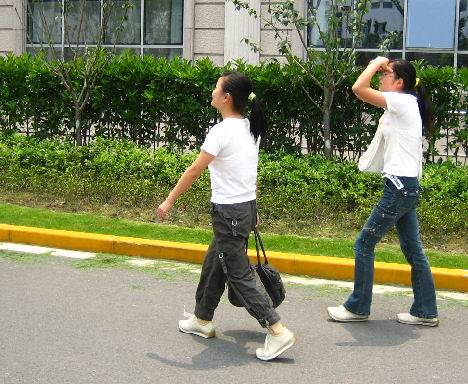

In [1]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00004.png')
temp_image = Image.open('PennFudanPed/PNGImages/FudanPed00012.png')
print(temp_image.size)
temp_image

(array([2, 5]),)
one == othernum : 
 [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
pos :  (array([ 59,  59,  59, ..., 337, 337, 337]), array([236, 237, 238, ..., 203, 204, 205]))
pos[0] :  [ 59  59  59 ... 337 337 337]
boxes :  [[167, 59, 323, 337], [8, 60, 47, 179]]
[[[0]]

 [[1]]

 [[2]]]


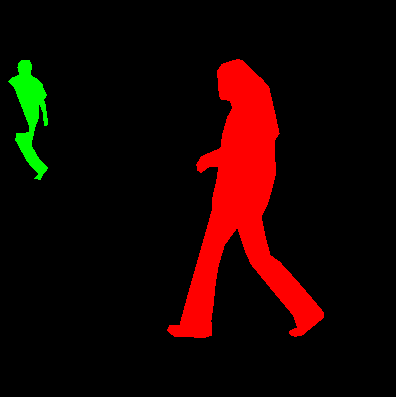

In [2]:
import numpy as np

mask = Image.open('PennFudanPed/PedMasks/FudanPed00004_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.


# ###################################### 그냥 한번 해본것#########################################
nparray = np.array([[False,False,True,False,False,True],[12,2,2,2,2]])
print(np.where(nparray[0]))

npmask = np.array(mask)

# for i in range(len(npmask)):
#     print(npmask[i])

obj_ids = np.unique(npmask)
obj_ids = obj_ids[1:]
masks = npmask == obj_ids[:, None, None]

one = np.array([[1],[2]])
othernum = np.array([[1,2,2,2,0,0,0],[2,0,0,0,0,0,1],[1,2,0,0,0,0,0],[2,1,2,1,2,1,0]])
masks = npmask == obj_ids[:, None, None]
print("one == othernum : \n" , masks)
#print(npmask)
pos = np.where(masks[0])
print("pos : " ,pos)
print("pos[0] : ", pos[0])

npmask = np.unique(npmask)
boxes = []
for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
print("boxes : ", boxes)
#print(npmask)
# ###############################################################################################
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is yellow
    0, 0, 255, # index 3 is orange
])
obj_ids = np.unique(npmask)
print(obj_ids[:,None,None])
mask

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # 첫번째 것은 배경이므로 지우자
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        # obj_ids안에 있는 값들은 True로 아닌 것들은 False로 들어감
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            # true인 곳의 위치들이 array로 pos에 들어감
            # where : 괄호 안에 참값이 들어갈 때 그 index값을 반환해줌 , 즉 좌표를 반환해줌 pos[0]은 y값들의 위치 pos[1]은 x값들의 위치
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # 그냥 가로 * 세로 로 면적 계산
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
dataset = PennFudanDataset('PennFudanPed/')

dataset[7]

(<PIL.Image.Image image mode=RGB size=388x454 at 0x7FCE142C2470>,
 {'boxes': tensor([[227., 157., 369., 435.],
          [ 38., 178., 114., 362.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([7]),
  'area': tensor([39476., 13984.]),
  'iscrowd': tensor([0, 0])})

In [3]:
import torchvision
import vision
from vision.torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from vision.torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # COCO에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다.
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = vision.torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_bg_iou_thresh = 0.01)
    # 분류를 위한 입력 특징 차원을 얻습니다.
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    #in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    
    #hidden_layer = 256
    # and replace the mask predictor with a new one
    #model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

    
    return model


















# def get_instance_segmentation_model(num_classes):
#     # COCO에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다.
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#     # 분류를 위한 입력 특징 차원을 얻습니다.
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model

In [4]:

# Download TorchVision repo to use some files from
# references/detection
#!sudo git clone https://github.com/pytorch/vision.git
#%cd vision
#!sudo git checkout v0.3.0

# !sudo cp references/detection/utils.py ../
# !sudo cp references/detection/transforms.py ../
# !sudo cp references/detection/coco_eval.py ../
# !sudo cp references/detection/engine.py ../
# !sudo cp references/detection/coco_utils.py ../

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', None)
dataset
# dataset_test = PennFudanDataset('PennFudanPed', None)

# # split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# # define training and validation data loaders
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=utils.collate_fn)

In [7]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
import torch.nn as nn
import os

#os.environ["CUDA_VISIBLE_DIVICES"] = '0, 1'
if torch.cuda.is_available():
    print("GPU")
else:
    print("CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

model = get_instance_segmentation_model(num_classes)
#model = model.cuda([0,1])
# if torch.cuda.device_count()>1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#   model = nn.DataParallel(model, output_device=1)

# move model to the right device
model.to(device)
#model.cuda()
# print(device)
# print(model)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

GPU
out_channels :  256
rpn_anchor_generator :  None
rpn_head :  None
rpn_anchor_generator :  AnchorGenerator()
rpn_head :  RPNHead(
  (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
)
rpn_pre_nms_top_n :  {'training': 2000, 'testing': 1000}
rpn_post_nms_top_n :  {'training': 2000, 'testing': 1000}
rpn :  RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)
box_roi_pool :  MultiScaleRoIAlign()
box_head :  TwoMLPHead(
  (fc6): Linear(in_features=12544, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
)
box_predictor :  FastRCNNPredictor(
 

In [11]:
# let's train it for 10 epochs
num_epochs = 10

#evaluate(model, data_loader_test, device=device)
# print("model : ", model)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# print("optimizer : ", optimizer)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# print("data_loader : ", data_loader)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# print("device : ", device)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# print("epoch : ", epoch)
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:02:30  lr: 0.000009  loss: 1.2302 (1.2302)  loss_classifier: 1.0216 (1.0216)  loss_box_reg: 0.2010 (0.2010)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 2.5134  data: 0.7318  max mem: 3078
Epoch: [0]  [ 1/60]  eta: 0:01:23  lr: 0.000017  loss: 1.2302 (1.2646)  loss_classifier: 1.0216 (1.0485)  loss_box_reg: 0.2010 (0.2081)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0062 (0.0069)  time: 1.4193  data: 0.3787  max mem: 3078
Epoch: [0]  [ 2/60]  eta: 0:01:00  lr: 0.000026  loss: 1.2990 (1.3014)  loss_classifier: 1.0504 (1.0491)  loss_box_reg: 0.2152 (0.2373)  loss_objectness: 0.0023 (0.0039)  loss_rpn_box_reg: 0.0076 (0.0111)  time: 1.0414  data: 0.2531  max mem: 3078
Epoch: [0]  [ 3/60]  eta: 0:00:49  lr: 0.000034  loss: 1.2487 (1.2882)  loss_classifier: 1.0216 (1.0196)  loss_box_reg: 0.2152 (0.2534)  loss_objectness: 0.0022 (0.0035)  loss_rpn_box_reg: 0.0076 (0.0117)  time: 0.8604  data: 0.1901  max mem: 3078
Epoch: [

Epoch: [0]  [34/60]  eta: 0:00:09  lr: 0.000297  loss: 0.4517 (0.7513)  loss_classifier: 0.2295 (0.5053)  loss_box_reg: 0.1930 (0.2241)  loss_objectness: 0.0074 (0.0106)  loss_rpn_box_reg: 0.0085 (0.0114)  time: 0.3008  data: 0.0096  max mem: 3317
Epoch: [0]  [35/60]  eta: 0:00:09  lr: 0.000305  loss: 0.4467 (0.7356)  loss_classifier: 0.2228 (0.4938)  loss_box_reg: 0.1872 (0.2202)  loss_objectness: 0.0071 (0.0105)  loss_rpn_box_reg: 0.0084 (0.0112)  time: 0.2989  data: 0.0095  max mem: 3317
Epoch: [0]  [36/60]  eta: 0:00:08  lr: 0.000314  loss: 0.4032 (0.7260)  loss_classifier: 0.2038 (0.4854)  loss_box_reg: 0.1826 (0.2190)  loss_objectness: 0.0071 (0.0104)  loss_rpn_box_reg: 0.0084 (0.0113)  time: 0.2962  data: 0.0096  max mem: 3317
Epoch: [0]  [37/60]  eta: 0:00:08  lr: 0.000322  loss: 0.4032 (0.7183)  loss_classifier: 0.2009 (0.4779)  loss_box_reg: 0.1826 (0.2188)  loss_objectness: 0.0071 (0.0102)  loss_rpn_box_reg: 0.0084 (0.0114)  time: 0.2992  data: 0.0089  max mem: 3317
Epoch: [

KeyboardInterrupt: 

In [50]:
import math
import sys
import time
import torch
import torchvision.models.detection.mask_rcnn
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils
def train_one_epoch2(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        """
        loss_dict
        {'loss_classifier': tensor(0.2272, device='cuda:0', grad_fn=<NllLossBackward>), 
         'loss_box_reg': tensor(0.1460, device='cuda:0', grad_fn=<DivBackward0>), 
         'loss_objectness': tensor(0.0318, device='cuda:0',
          grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 
         'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}        
        
        
        losses
        tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>) 
    
        """

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [12]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [13]:
prediction

[{'boxes': tensor([[ 67.5137,  32.1629, 198.3244, 338.6736],
          [ 75.8306,  52.9721, 156.4264, 287.4428],
          [275.1823,  21.2315, 291.3158,  77.0613],
          [ 91.4866,  26.1273, 192.0441, 218.9536],
          [ 89.7272, 117.2182, 187.5378, 319.6942],
          [ 38.2978,  60.9397, 149.1483, 346.8134],
          [282.5278,  15.4515, 291.9344,  71.0047],
          [ 31.4470,  20.0153, 272.9643, 311.2735],
          [279.7413,  24.1526, 289.8393,  67.4638],
          [273.3768,  19.2137, 284.8529,  72.2077],
          [ 72.2124,  39.4496, 141.2353, 206.6828],
          [ 66.7202, 148.2722, 156.7230, 329.9384],
          [278.1425,  38.4683, 292.0000,  70.4840],
          [ 57.4409, 165.1706, 214.3965, 349.0000],
          [ 10.7732,   0.0000, 193.6326, 262.4565],
          [ 49.2237,  82.5805, 191.4501, 174.4803],
          [119.8011,  88.6091, 206.9466, 303.7243],
          [277.2316,  26.0193, 285.9561,  63.4444],
          [  0.0000, 100.4612, 226.3696, 293.8911],
   

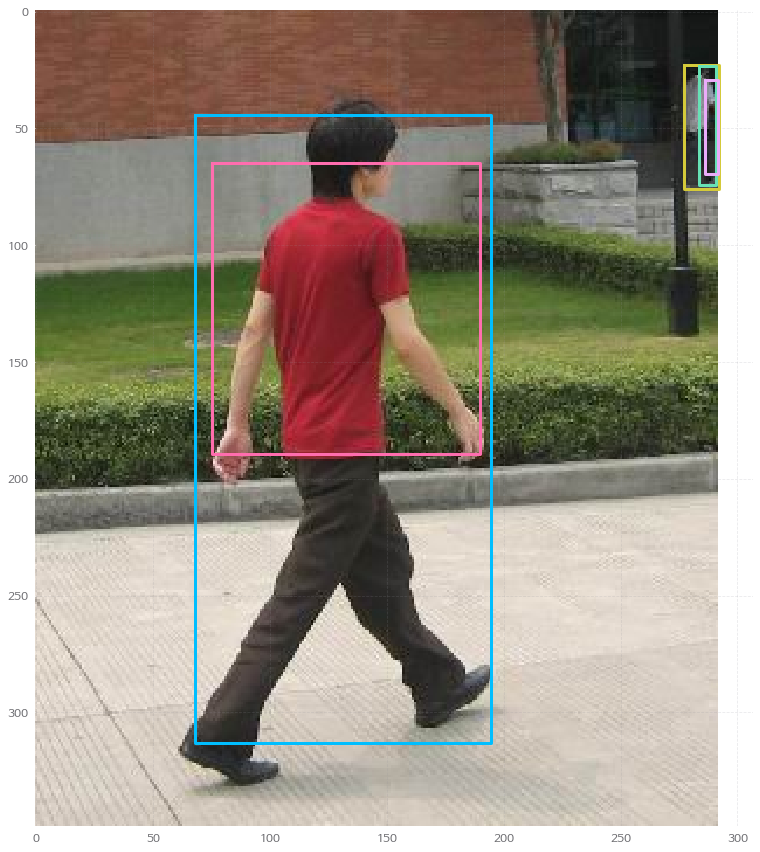

In [53]:
from matplotlib import pyplot as plt
import numpy
plt.figure(figsize = (15,15))
# tensor([[317.0266,  65.5659, 453.2461, 347.0377],
#         [169.0079,  27.5498, 244.5284, 313.9996]

plt.imshow(img.permute(1, 2, 0))


The_boxes = (prediction[0]['boxes']).tolist()
for box in The_boxes:
  x_values = [box[0], box[0], box[2], box[2], box[0]]
  y_values = [box[1], box[3], box[3], box[1], box[1]]
  plt.plot(x_values, y_values, linewidth = 3)

In [ ]:
#Image.fromarray(prediction[0]['masks'][4, 0].mul(255).byte().cpu().numpy())

#print(prediction[0].keys())

In [78]:
def is_correct(p):
    open_num = 0
    for i in p:
        if(i == '('):
            open_num +=1
        else:
            open_num -=1    
        
        if open_num < 0:
            return False
        
    if open_num == 0:
        return True
    else:
        return False
    
def is_balanced(p):
    open_num, close_num = 0, 0

    
    for i in p:
        if(i == '('):
            open_num +=1
        else:
            close_num +=1
    if(open_num == close_num):
        return True
    else:
        return False
    
def stage2(p, answer):
    if len(p) == 0:
        return p
    u = ""
    v = ""
    for i in range(1, len(p)):
        if is_balanced(p[0:i + 1]):
            u = p[0:i + 1]                
            v = p[i+1:len(p)]
            break
    
    empty_str = ""
    
    if is_correct(u):
        
        u += stage2(v, answer)
        return u
    else:
        empty_str += "("
        empty_str += stage2(v, answer)
        empty_str += ")"
        u = u[1:-1]
        temp_str = ""
        for j in range(len(u)):
            if u[j] =='(':
                temp_str += ')'
            else:
                temp_str += '('
        empty_str += temp_str
        return empty_str
    return u
    
def solution(p):
    answer = ''
    answer = stage2(p, "")
                
    return answer



In [79]:
solution("()))((()")

'()(())()'

In [1]:
s1_1 = set("111","222","333","444","555","666","777","888","999","000", )
s1_2 = set("1111","2222","3333","4444","5555","6666","7777","8888","9999","0000", )
s1_3 = set("11111","22222","33333","44444","55555","66666","77777","88888","99999","00000", )
s2_1 = set("123","234","345","456","567","678","789","012",
           "210","321","432","543","654","765","876","987",
          "1234","2345","3456","4567","5678","6789", "0123",
           "3210","4321","5432","6543","7654","8765","9876",
           "43210","54321","65432","76543","87654","98765",
          "12345","23456","34567","45678","56789","01234")

solver(STR)





3]


In [12]:
mySTR = ""
for i in range(2,10):
    mySTR += ('\"' + str(i) + str(i-1)+ str(i-2) + "\"")
    mySTR +=","          
print(mySTR)
mySTR = ""
for i in range(3,10):
    mySTR += ("\"" + str(i) + str(i-1)+ str(i-2) + str(i-3) + "\"") 
    mySTR +=","          

print(mySTR)
mySTR = ""
for i in range(4,10):
    mySTR += ("\"" + str(i) + str(i-1)+ str(i-2) + str(i-3) + str(i-4) + "\"") 
    mySTR +=","          

print(mySTR)

    

"210","321","432","543","654","765","876","987",
"3210","4321","5432","6543","7654","8765","9876",
"43210","54321","65432","76543","87654","98765",
